In [1]:
import ccxt.pro as ccxtpro
import asyncio
import nest_asyncio
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm

nest_asyncio.apply()

with open('binance_api.txt', 'r') as file:
    api_key = file.readline().strip()
    secret = file.readline().strip()

exchange = ccxtpro.binance({
    'apiKey': api_key,
    'secret': secret,
    'enableRateLimit': True,  # 요청 비율 제한 활성화
    'options': {'defaultType': 'future'}  # Perpetual 선물 시장을 선택합니다.
})

In [2]:
async def fetch_symbol_data(exchange, symbol, since):
    """
    특정 심볼의 OHLCV 데이터를 가져와 일 단위로 거래량을 USDT로 변환한 후 3년치 총 거래량을 반환합니다.

    입력값:
    - exchange: ccxtpro 거래소 객체
    - symbol: 심볼 문자열
    - since: 데이터 시작 시점 (timestamp)

    출력값:
    - (symbol, total_usdt_volume, df): 심볼, 총 USDT 거래량, 데이터프레임의 튜플
    """
    try:
        all_ohlcv = []
        while since < exchange.milliseconds():
            ohlcv = await exchange.fetch_ohlcv(symbol, '1d', since=since, limit=500)
            if not ohlcv:
                break
            all_ohlcv += ohlcv
            since = ohlcv[-1][0] + 1  # 마지막 timestamp를 업데이트하여 다음 batch의 데이터를 가져옴

        df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['quote_volume'] = df['volume'] * df['close']  # 일 단위로 거래량을 USDT로 환산
        total_usdt_volume = df['quote_volume'].sum()
        return symbol, total_usdt_volume, df
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return symbol, 0, None

async def get_top_symbols_by_volume(exchange, n=40):
    """
    지난 3년 동안의 거래량을 USDT 기준으로 상위 n개의 심볼을 선택하고 해당 데이터를 반환합니다.

    입력값:
    - exchange: ccxtpro 거래소 객체
    - n: 선택할 심볼의 개수

    출력값:
    - top_symbols: (symbol, total_usdt_volume, df) 튜플의 리스트 (상위 n개 심볼의 데이터)
    """
    await exchange.load_markets()
    symbols = []

    for symbol in exchange.markets:
        if exchange.markets[symbol]['active'] and '/USDT' in symbol:
            symbols.append(symbol)

    three_years_ago = exchange.parse8601((datetime.now() - timedelta(days=3*365+180)).strftime('%Y-%m-%dT%H:%M:%SZ'))

    tasks = [fetch_symbol_data(exchange, symbol, three_years_ago) for symbol in symbols]
    volume_data = await asyncio.gather(*tasks)

    # 중복 제거를 위한 집합
    seen_symbols = set()
    unique_volume_data = []
    for symbol, total_usdt_volume, df in volume_data:
        clean_symbol = symbol.split(':')[0]
        perp_symbol = clean_symbol + ':USDT'
        if perp_symbol not in seen_symbols and df is not None:
            seen_symbols.add(perp_symbol)
            unique_volume_data.append((symbol, total_usdt_volume, df))

    # 상위 n개의 종목 선택
    top_symbols_by_volume = sorted(unique_volume_data, key=lambda x: x[1], reverse=True)

    # 디버깅 출력
    print("Top symbols by volume before filtering:", [symbol for symbol, _, _ in top_symbols_by_volume[:50]])

    # BTC/USDT의 데이터 길이 구하기
    btc_data = [df for symbol, _, df in top_symbols_by_volume if 'BTC/USDT' in symbol]
    if not btc_data:
        raise Exception("BTC/USDT data not found in the top symbols")
    btc_length = len(btc_data[0])

    # 데이터 길이가 부족한 티커 제거 및 차순위 티커 추가
    filtered_symbols = []
    i = len(top_symbols_by_volume)
    while len(filtered_symbols) < n and top_symbols_by_volume:
        symbol, total_usdt_volume, df = top_symbols_by_volume.pop(0)
        if df is not None and len(df) >= btc_length:
            filtered_symbols.append((symbol, total_usdt_volume, df))
        else:
            if i < len(unique_volume_data):
                next_symbol = unique_volume_data[i]
                i += 1
                top_symbols_by_volume.append(next_symbol)
    
    # 최종 상위 n개의 종목 선택 후 중복 제거
    perpetual_symbols = []
    seen_symbols.clear()
    for symbol, total_usdt_volume, df in filtered_symbols:
        clean_symbol = symbol.split(':')[0]
        perp_symbol = clean_symbol + ':USDT'
        if perp_symbol in exchange.markets and perp_symbol not in seen_symbols:
            perp_data = await fetch_symbol_data(exchange, perp_symbol, three_years_ago)
            if perp_data[2] is not None and len(perp_data[2]) >= btc_length:
                seen_symbols.add(perp_symbol)
                perpetual_symbols.append(perp_data)

    # 시계열적 길이 확인
    lengths = [len(df) for _, _, df in perpetual_symbols]
    print("Data lengths of selected symbols:", lengths)

    return perpetual_symbols

In [3]:
# 심볼 데이터 준비
top_symbols_data = asyncio.run(get_top_symbols_by_volume(exchange, 40))
symbols = [symbol for symbol, total_volume, df in top_symbols_data]
print(f"Top 40 symbols by volume: {symbols}")
# top_symbols_data = asyncio.run(get_top_symbols_by_volume(exchange, 40))
# print(f"Top 40 symbols by volume: {[symbol for symbol, total_volume, df in top_symbols_data]}")

Error fetching data for TUSD/USDT: binance does not have market symbol TUSD/USDT
Error fetching data for NULS/USDT: binance does not have market symbol NULS/USDT
Error fetching data for TFUEL/USDT: binance does not have market symbol TFUEL/USDT
Error fetching data for WIN/USDT: binance does not have market symbol WIN/USDT
Error fetching data for COS/USDT: binance does not have market symbol COS/USDT
Error fetching data for WAN/USDT: binance does not have market symbol WAN/USDT
Error fetching data for FUN/USDT: binance does not have market symbol FUN/USDT
Error fetching data for CTXC/USDT: binance does not have market symbol CTXC/USDT
Error fetching data for TROY/USDT: binance does not have market symbol TROY/USDT
Error fetching data for VITE/USDT: binance does not have market symbol VITE/USDT
Error fetching data for EUR/USDT: binance does not have market symbol EUR/USDT
Error fetching data for WRX/USDT: binance does not have market symbol WRX/USDT
Error fetching data for LTO/USDT: bina

In [9]:
import pandas as pd
import numpy as np
import warnings
import os
import csv

warnings.filterwarnings('ignore')

def convert_to_utc(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    return df

def calculate_monthly_returns(data):
    """
    각 종목의 직전 시점 종가와의 가격 차이를 이용하여 월별 수익률을 계산하고 추가합니다.

    입력값:
    - df: OHLCV+quote_volume 데이터프레임 (pandas.DataFrame)

    출력값:
    - df: 월별 수익률이 추가된 데이터프레임 (pandas.DataFrame)
    """
    data = data.copy()
    monthly_close = data.xs('close', axis=1, level=1)
    monthly_return = (monthly_close.shift(-1) / monthly_close) - 1  # 다음 달과의 비교를 위해 shift(-1) 추가
    for symbol in monthly_close.columns:
        data[(symbol, 'monthly_return')] = monthly_return[symbol]
    data = reorder_columns(data)  # 컬럼 순서 조정 함수 호출
    return data

def reorder_columns(df):
    symbols = df.columns.get_level_values(0).unique()
    ordered_cols = []
    for symbol in symbols:
        cols = df[symbol].columns.tolist()
        order = ['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'momentum', 'monthly_return', 'Salience']
        ordered_cols.extend([(symbol, col) for col in order if col in cols])
    return df[ordered_cols]

def calculate_salience(ohlcv_df, combined_df, lookback_period=126):
    ohlcv_df = ohlcv_df.copy()
    combined_df = combined_df.copy()
    symbols = combined_df.columns.get_level_values(0).unique()
    
    for symbol in symbols:
        ohlcv_df[(symbol, 'Return')] = ohlcv_df[(symbol, 'close')].pct_change()
        ohlcv_df[(symbol, 'MA')] = ohlcv_df[(symbol, 'Return')].rolling(window=30).mean()
    
    ohlcv_df['Mean_MA'] = ohlcv_df.xs('MA', axis=1, level=1).mean(axis=1)
    
    salience_values = pd.DataFrame(index=ohlcv_df.index, columns=pd.MultiIndex.from_product([symbols, ['Salience']]))
    for symbol in symbols:
        salience_values[(symbol, 'Salience')] = np.abs(ohlcv_df[(symbol, 'Return')] - ohlcv_df['Mean_MA']) / ohlcv_df[(symbol, 'Return')].rolling(window=lookback_period).std()
    
    for symbol in symbols:
        monthly_salience = salience_values[(symbol, 'Salience')].resample('M').mean()
        combined_df[(symbol, 'Salience')] = monthly_salience.values
    
    return combined_df

def calculate_returns(df):
    df = df.copy()
    df['returns'] = df['close'].pct_change()
    df['margin_call'] = df['high'] >= 2 * df['close'].shift(1)
    df['cumulative_returns'] = 1
    margin_call_triggered = False
    for i in range(1, len(df)):
        if margin_call_triggered or df['margin_call'].iloc[i]:
            df['cumulative_returns'].iloc[i] = 0
            margin_call_triggered = True
        else:
            df['cumulative_returns'].iloc[i] = df['cumulative_returns'].iloc[i - 1] * (1 + df['returns'].iloc[i])
            if df['cumulative_returns'].iloc[i] < 0:
                df['cumulative_returns'].iloc[i] = 0
    df['cumulative_returns'] = df['cumulative_returns'] - 1
    return df

def calculate_momentum(data, months_lookback=12, months_skip=1, reversion=False):
    data = data.copy()
    monthly_close = data.xs('close', axis=1, level=1)
    if reversion:
        # momentum = (monthly_close / monthly_close.shift(months_skip)) - 1
        momentum = np.log(monthly_close / monthly_close.shift(months_skip))
    else:
        # momentum = (monthly_close.shift(months_skip) / monthly_close.shift(months_lookback)) - 1
        momentum = np.log(monthly_close.shift(months_skip) / monthly_close.shift(months_lookback))
    for symbol in monthly_close.columns:
        data[(symbol, 'momentum')] = momentum[symbol]
    data = reorder_columns(data)
    return data

def determine_weights_based_on_returns(recent_month_return_rank, n_positions=8):
    quantile = recent_month_return_rank.quantile([0.2, 0.4, 0.6, 0.8])
    rank = recent_month_return_rank.iloc[-1]  # 최근 월의 순위

    if rank <= quantile[0.2]:
        return n_positions // 4, (3 * n_positions) // 4, 0.5, 1.5
    elif rank <= quantile[0.4]:
        return (3 * n_positions) // 8, (5 * n_positions) // 8, 0.75, 1.25
    elif rank <= quantile[0.6]:
        return n_positions // 2, n_positions // 2, 1.0, 1.0
    elif rank <= quantile[0.8]:
        return (5 * n_positions) // 8, (3 * n_positions) // 8, 1.25, 0.75
    else:
        return (3 * n_positions) // 4, n_positions // 4, 1.5, 0.5

def set_positions(monthly_combined_df, date, n_positions=8, use_return_adjustment=True):
    """
    해당 월에 롱/숏 포지션을 설정합니다.

    입력값:
    - monthly_combined_df: 월별 OHLCV 데이터프레임 (pandas.DataFrame)
    - date: 현재 날짜 (Timestamp)
    - n_positions: 포지션에 포함할 종목 수 (int, default=8)
    - use_return_adjustment: 과거 수익률을 기반으로 롱/숏 비중을 추가조정할지 여부 (bool, default=True)

    출력값:
    - long_positions, short_positions: 롱/숏 포지션 종목 리스트
    - long_weight_factor, short_weight_factor: 롱/숏 포지션 가중치
    """
    recent_month_returns = monthly_combined_df.loc[date, (slice(None), 'monthly_return')]
    recent_month_return_rank = recent_month_returns.rank(ascending=False)
    if use_return_adjustment:
        long_positions_count, short_positions_count, long_weight_factor, short_weight_factor = determine_weights_based_on_returns(recent_month_return_rank, n_positions)
    else:
        long_positions_count, short_positions_count = n_positions // 2, n_positions // 2
        long_weight_factor, short_weight_factor = 1.0, 1.0

    long_positions = recent_month_return_rank.nlargest(long_positions_count).index.get_level_values(0).tolist()
    short_positions = recent_month_return_rank.nsmallest(short_positions_count).index.get_level_values(0).tolist()
    
    return long_positions, short_positions, long_weight_factor, short_weight_factor

def calculate_weights(monthly_combined_df, date, long_positions, short_positions, long_weight_factor, short_weight_factor, use_salience, inverse_salience):
    """
    롱/숏 포지션의 가중치를 계산합니다.

    입력값:
    - combined_df: 월별 OHLCV 데이터프레임 (pandas.DataFrame)
    - date: 현재 날짜 (Timestamp)
    - long_positions, short_positions: 롱/숏 포지션 종목 리스트
    - long_weight_factor, short_weight_factor: 롱/숏 포지션 가중치
    - use_salience: Salience를 사용할지 여부 (bool)
    - inverse_salience: Salience의 역으로 가중치를 줄지 여부 (bool)

    출력값:
    - weights: 종목별 가중치 (dict)
    """
    l_weights = {}
    s_weights = {}
    
    if use_salience:
        salience_values = monthly_combined_df.loc[date, (slice(None), 'Salience')]
        long_salience_values = salience_values.loc[long_positions]
        short_salience_values = salience_values.loc[short_positions]
        
        if inverse_salience:
            long_salience_values = 1 / (long_salience_values + 1e-9)
            short_salience_values = 1 / (short_salience_values + 1e-9)
        
        long_salience_sum = long_salience_values.sum()
        short_salience_sum = short_salience_values.sum()
        
        for pos in long_positions:
            salience_value = long_salience_values[pos, 'Salience']
            l_weights[pos] = long_weight_factor * (salience_value / long_salience_sum)
        
        for pos in short_positions:
            salience_value = short_salience_values[pos, 'Salience']
            s_weights[pos] = short_weight_factor * (salience_value / short_salience_sum)
    else:
        long_weight = long_weight_factor / len(long_positions)
        short_weight = short_weight_factor / len(short_positions)
        
        for pos in long_positions:
            l_weights[pos] = long_weight
        
        for pos in short_positions:
            s_weights[pos] = short_weight
    
    # Ensure the sum of weights is 2
    l_total_weight = sum(l_weights.values())
    s_total_weight = sum(s_weights.values())
    total_weight = l_total_weight + s_total_weight
    weight_adjustment_factor = 2 / total_weight
    
    for pos in l_weights:
        l_weights[pos] *= weight_adjustment_factor
    for pos in s_weights:
        s_weights[pos] *= weight_adjustment_factor
    
    weights = {**l_weights, **s_weights}
    return weights


def backtest_strategy(monthly_combined_df, combined_df, n_positions=8, use_salience=True, reverse_positions=False, use_return_adjustment=True, inverse_salience=False, initial_investment=2):
    log_file = os.path.join('strategy_results', f'{n_positions}_{use_salience}_{reverse_positions}_{use_return_adjustment}_{inverse_salience}_backtest_log.csv')
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Date', 'Long Positions', 'Short Positions', 'Long Weights', 'Short Weights', 'Monthly Return', 'Cumulative Return'])
    
    monthly_returns = []
    cumulative_returns = [initial_investment]
    dates = monthly_combined_df.index.get_level_values(0).unique()
    
    for date in dates[12:-1]:
        long_positions, short_positions, long_weight_factor, short_weight_factor = set_positions(monthly_combined_df, date, n_positions, use_return_adjustment)
        if reverse_positions:
            long_positions, short_positions = short_positions, long_positions
            long_weight_factor, short_weight_factor = short_weight_factor, long_weight_factor
        
        weights = calculate_weights(monthly_combined_df, date, long_positions, short_positions, long_weight_factor, short_weight_factor, use_salience, inverse_salience)
        
        long_weights = {pos: weights[pos] for pos in long_positions}
        short_weights = {pos: weights[pos] for pos in short_positions}
        
        monthly_return = 0
        next_date = dates[dates.get_loc(date) + 1]
        
        for symbol in long_positions:
            symbol_return = monthly_combined_df.loc[next_date, (symbol, 'monthly_return')]
            weight = weights[symbol]
            monthly_return += symbol_return * weight
        
        for symbol in short_positions:
            symbol_return = monthly_combined_df.loc[next_date, (symbol, 'monthly_return')]
            weight = weights[symbol]
            monthly_return -= symbol_return * weight
        
        if np.isnan(monthly_return):
            monthly_return = 0
        
        monthly_returns.append(monthly_return)
        
        new_cumulative_return = cumulative_returns[-1] * (1 + monthly_return)
        cumulative_returns.append(new_cumulative_return)
        
        with open(log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([date, long_positions, short_positions, long_weights, short_weights, monthly_return, new_cumulative_return])
    
    if np.isnan(cumulative_returns[-1]):
        cumulative_returns = cumulative_returns[:-1]
    
    if np.isnan(monthly_returns[-1]):
        monthly_returns = monthly_returns[:-1]
    
    sharpe_ratio = calculate_sharpe_ratio(monthly_returns)
    max_drawdown = calculate_max_drawdown(cumulative_returns)

    return monthly_returns, cumulative_returns, sharpe_ratio, max_drawdown

def calculate_sharpe_ratio(monthly_returns, risk_free_rate=0.02):
    """
    샤프 비율을 계산합니다. 1년을 기준으로 합니다.

    입력값:
    - monthly_returns: 월별 수익률 (list)
    - risk_free_rate: 무위험 수익률 (float, default=0.02)

    출력값:
    - sharpe_ratio: 샤프 비율 (float)
    """
    mean_return = np.mean(monthly_returns)
    std_return = np.std(monthly_returns)
    annualized_return = mean_return * 12
    annualized_std = std_return * np.sqrt(12)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    return sharpe_ratio

def calculate_max_drawdown(cumulative_returns):
    """
    최대 손실 낙폭(MDD)을 계산합니다.

    입력값:
    - cumulative_returns: 누적 수익률 (list)

    출력값:
    - max_drawdown: 최대 손실 낙폭 (float)
    """
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_max - cumulative_returns
    max_drawdown = np.max(drawdown) / cumulative_max[np.argmax(drawdown)]
    return max_drawdown

In [10]:
from itertools import product
from tqdm import tqdm
import plotly.express as px

# Main processing
for i, (symbol, total_volume, df) in enumerate(top_symbols_data):
    if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df.index):
        df = df.copy()
        df = convert_to_utc(df)
        df.set_index('timestamp', inplace=True)
        top_symbols_data[i] = (symbol, total_volume, df)

errorcount = 0
test0 = top_symbols_data[0][2]
for test in [df for _, _, df in top_symbols_data][1:]:
    val = pd.Series(test0.index == test.index).unique()
    if len(val) != 1 or val[0] != True:
        errorcount += 1
print(f"Number of datasets with mismatched dates: {errorcount}")

output_dir = 'strategy_results'
os.makedirs(output_dir, exist_ok=True)

monthly_top_symbols_data = []
for symbol, _, df in top_symbols_data:
    monthly_top = df.resample('M').last().dropna()
    monthly_top_symbols_data.append((symbol, monthly_top))

combined_df = pd.concat({symbol: df for symbol, _, df in top_symbols_data}, axis=1)
monthly_combined_df = pd.concat({symbol: df for symbol, df in monthly_top_symbols_data}, axis=1)
monthly_combined_df = reorder_columns(calculate_monthly_returns(calculate_momentum(monthly_combined_df,months_skip=1, reversion=True)))
monthly_combined_df = calculate_salience(combined_df, monthly_combined_df)
# # 백테스트 실행 및 결과 출력
# monthly_returns, cumulative_returns, sharpe_ratio, max_drawdown = backtest_strategy(monthly_combined_df, combined_df)

# print("Monthly Returns:", monthly_returns)
# print("Cumulative Returns:", cumulative_returns)
# print("Sharpe Ratio:", sharpe_ratio)
# print("Max Drawdown:", max_drawdown)

Number of datasets with mismatched dates: 0


In [11]:
# Define the parameters for the backtests
n_positions_list = [8, 16, 24, 32, 40]
use_salience_list = [True, False]
reverse_positions_list = [True, False]
use_return_adjustment_list = [True, False]

# Create a list of parameter combinations
params_list = []
for use_salience in use_salience_list:
    inverse_salience_options = [True, False] if use_salience else [False]
    params_combinations = product(
        n_positions_list, [use_salience], reverse_positions_list, use_return_adjustment_list, inverse_salience_options
    )
    params_list.extend(params_combinations)

# Convert combinations into list of dicts
params_list = [
    {
        'n_positions': n_positions,
        'use_salience': use_salience,
        'reverse_positions': reverse_positions,
        'use_return_adjustment': use_return_adjustment,
        'inverse_salience': inverse_salience
    }
    for n_positions, use_salience, reverse_positions, use_return_adjustment, inverse_salience in params_list
]

# Run the backtests with tqdm progress bar
results = []
sharpe_ratios = []
dates = monthly_combined_df.index.get_level_values(0).unique()[12:-1]  # Align with the backtest period
for params in tqdm(params_list, desc="Running Backtests"):
    monthly_returns, cumulative_returns, sharpe_ratio, max_drawdown = backtest_strategy(
        monthly_combined_df, combined_df, 
        n_positions=params['n_positions'], 
        use_salience=params['use_salience'], 
        reverse_positions=params['reverse_positions'], 
        use_return_adjustment=params['use_return_adjustment'], 
        inverse_salience=params['inverse_salience'], 
        initial_investment=2
    )
    cumulative_returns_series = pd.Series(cumulative_returns[:-1], index=dates) 
    results.append({
        'params': params,
        'cumulative_returns': cumulative_returns_series,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    })
    sharpe_ratios.append({
        'params': str(params),
        'sharpe_ratio': sharpe_ratio
    })

Running Backtests: 100%|███████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.67it/s]


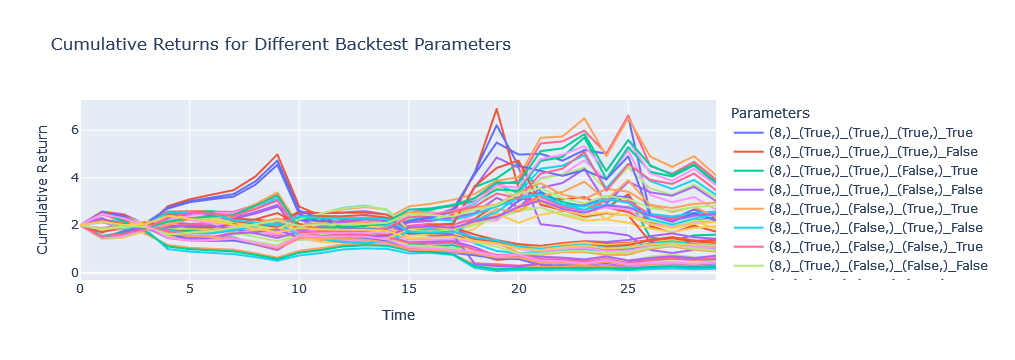

In [12]:
# Prepare data for Plotly visualization
plot_data = []
for result in results:
    params = result['params']
    n_positions=params['n_positions'],# 총 투자종목수
    use_salience=params['use_salience'], #salience를 이용한 비중 가중치
    reverse_positions=params['reverse_positions'], #역포지션
    use_return_adjustment=params['use_return_adjustment'], #TS를 이용해 롱-숏 비대칭 비중 조정 사용 여부
    inverse_salience=params['inverse_salience']#salience의 역 가중 사용
    for i, value in enumerate(result['cumulative_returns']):
        plot_data.append({
            'Time': i,
            'Cumulative Return': value,
            'Parameters': f'{n_positions}_{use_salience}_{reverse_positions}_{use_return_adjustment}_{inverse_salience}'
        })

plot_df = pd.DataFrame(plot_data)

# Visualize the cumulative returns for different backtest parameters using Plotly Express
fig = px.line(plot_df, x='Time', y='Cumulative Return', color='Parameters', title='Cumulative Returns for Different Backtest Parameters')
fig.show()

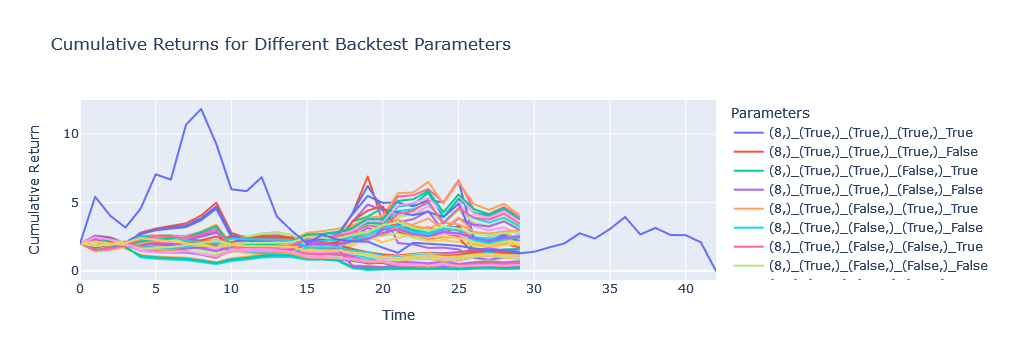

In [13]:
# Calculate 40 equal weight holding return
initial_investment = 2
num_assets = 40
equal_weight = initial_investment / num_assets

# Calculate the return for each asset
equal_weight_returns = monthly_combined_df.xs('monthly_return', axis=1, level=1)
equal_weight_cumulative_return = (equal_weight_returns + 1).cumprod() * equal_weight

# Calculate the total portfolio value over time
equal_weight_total_return = equal_weight_cumulative_return.sum(axis=1)

# Adjust the initial value to match the initial investment
equal_weight_total_return = pd.concat([pd.Series([initial_investment], index=[dates[0]]), equal_weight_total_return.iloc[1:]])

# Calculate the Sharpe ratio for the equal weight holding return
equal_weight_monthly_returns = equal_weight_total_return.pct_change().dropna()
equal_weight_sharpe_ratio = (equal_weight_monthly_returns.mean() / equal_weight_monthly_returns.std()) * np.sqrt(12)
sharpe_ratios.append({
    'params': 'Equal Weight Holding',
    'sharpe_ratio': equal_weight_sharpe_ratio
})

# Prepare data for Plotly visualization
plot_data = []
for result in results:
    params = result['params']
    n_positions=params['n_positions'],# 총 투자종목수
    use_salience=params['use_salience'], #salience를 이용한 비중 가중치
    reverse_positions=params['reverse_positions'], #역포지션
    use_return_adjustment=params['use_return_adjustment'], #TS를 이용해 롱-숏 비대칭 비중 조정 사용 여부
    inverse_salience=params['inverse_salience']#salience의 역 가중 사용
    for i, value in enumerate(result['cumulative_returns']):
        plot_data.append({
            'Time': i,
            'Cumulative Return': value,
            'Parameters': f'{n_positions}_{use_salience}_{reverse_positions}_{use_return_adjustment}_{inverse_salience}'
        })

# Add the equal weight holding return to the plot data
for i, value in enumerate(equal_weight_total_return):
    plot_data.append({
        'Time': i,
        'Cumulative Return': value,
        'Parameters': 'Equal Weight Holding'
    })

plot_df = pd.DataFrame(plot_data)

# Visualize the cumulative returns for different backtest parameters using Plotly Express
fig = px.line(plot_df, x='Time', y='Cumulative Return', color='Parameters', title='Cumulative Returns for Different Backtest Parameters')
fig.show()

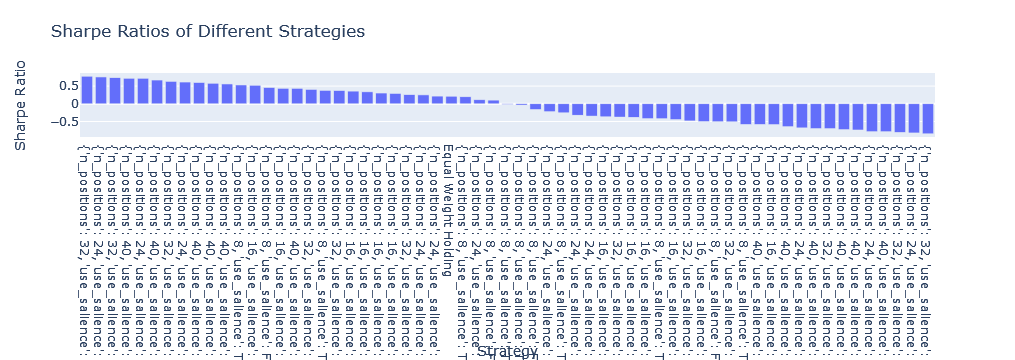

In [14]:
# Convert sharpe_ratios to DataFrame and sort by Sharpe ratio
sharpe_df = pd.DataFrame(sharpe_ratios).sort_values(by='sharpe_ratio', ascending=False)

# Visualize the Sharpe ratios
fig_sharpe = px.bar(sharpe_df, x='params', y='sharpe_ratio', title='Sharpe Ratios of Different Strategies', labels={'params': 'Strategy', 'sharpe_ratio': 'Sharpe Ratio'})
fig_sharpe.show()

In [18]:
sharpe_df.params

24    {'n_positions': 32, 'use_salience': True, 'rev...
16    {'n_positions': 24, 'use_salience': True, 'rev...
52    {'n_positions': 32, 'use_salience': False, 're...
32    {'n_positions': 40, 'use_salience': True, 'rev...
48    {'n_positions': 24, 'use_salience': False, 're...
                            ...                        
50    {'n_positions': 24, 'use_salience': False, 're...
36    {'n_positions': 40, 'use_salience': True, 'rev...
54    {'n_positions': 32, 'use_salience': False, 're...
20    {'n_positions': 24, 'use_salience': True, 'rev...
28    {'n_positions': 32, 'use_salience': True, 'rev...
Name: params, Length: 61, dtype: object